In [1]:
#Importing required packages
from astropy.io import fits
from astropy.stats import sigma_clipped_stats as scs
from astropy.convolution import convolve, Box1DKernel
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import linregress
from scipy.signal import savgol_filter
from scipy.stats import chisquare
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
#Loading the data file
#lc = fits.open(r'C:\Users\aswin\OneDrive\Desktop\ch2_xsm_20211111_v1_level2.lc')
lc = fits.open(r'C:\Users\aswin\OneDrive\Desktop\ch2_xsm_20211013_v1_level2.lc')

Text(0, 0.5, 'Counts')

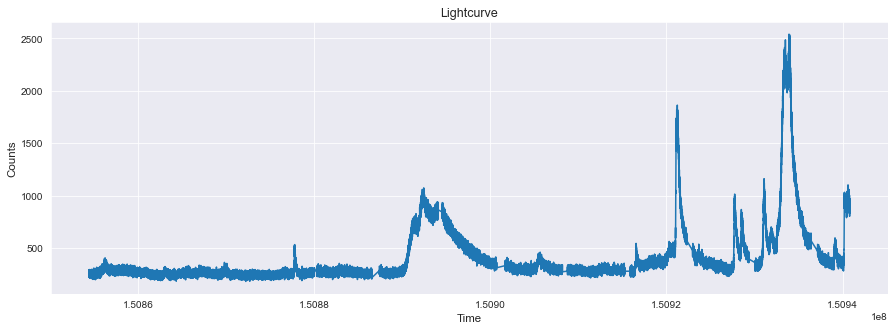

In [3]:
#Extracting count rates and time from the lc file
count_rate = lc['Rate'].data['Rate']
time = lc['Rate'].data['Time']
count_rate, time = np.array(count_rate), np.array(time)
plt.figure(0, figsize=(15,5))
plt.plot(time, count_rate)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Counts',fontsize = 11.5)

Text(0, 0.5, 'Background subtracted counts')

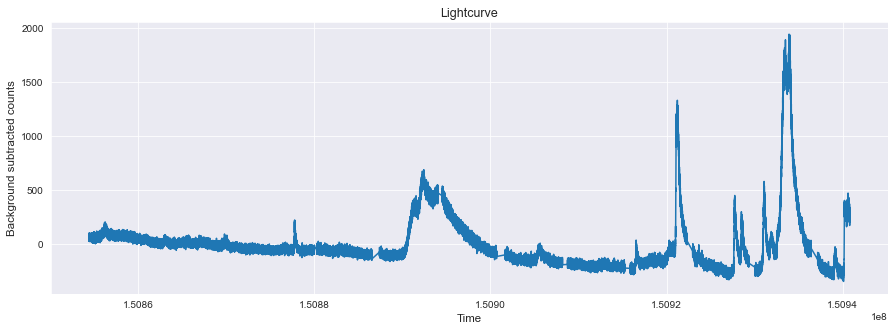

In [95]:
#Background subtraction
#Curvefit with a straight line
slope, intercept, r, p, se = linregress(time, count_rate)
#bksub_counts = count_rate - np.array(slope*time+intercept)
count_rate = count_rate - np.array(slope*time+intercept)
plt.figure(0, figsize=(15,5))
#plt.plot(time, bksub_counts)
plt.plot(time, count_rate)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Background subtracted counts',fontsize = 11.5)

Text(0, 0.5, 'Boxcar smoothed counts')

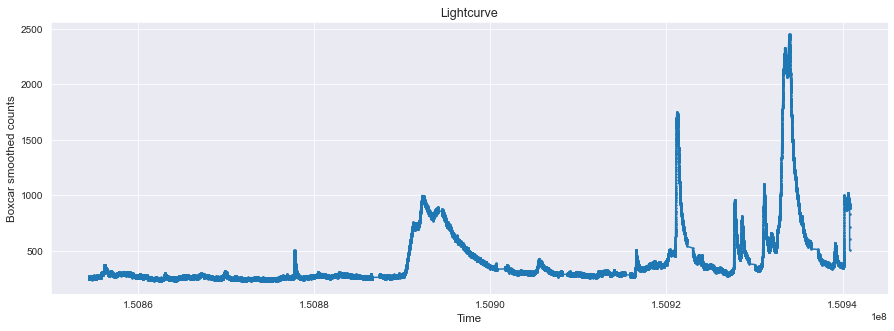

In [4]:
#box_car averaging
box_bin = 70
kernel_size = 8
box_time, box_count = np.array([]), np.array([])
for i in range(len(time[:])//box_bin):
    if(box_bin*i+i<=len(count_rate)):
        counts = count_rate[box_bin*i+i:box_bin*(i+1)+kernel_size+1+i]
        boxavg_counts = convolve(counts, Box1DKernel(kernel_size))[kernel_size//2:box_bin+kernel_size//2+1]
        box_count = np.concatenate((box_count, boxavg_counts))
        box_time = np.concatenate((box_time, time[box_bin*i+i+kernel_size//2:box_bin*(i+1)+kernel_size//2+1+i]))
        #plt.plot(time[box_bin*i:box_bin*(i+1)+kernel_size+1], counts, marker = '.', markersize = 3, alpha = 0.1)
    else:
        continue
plt.figure(0, figsize=(15,5))
plt.plot(box_time, box_count, marker = '.', markersize = 3)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Boxcar smoothed counts',fontsize = 11.5)

Text(0, 0.5, 'Binned counts')

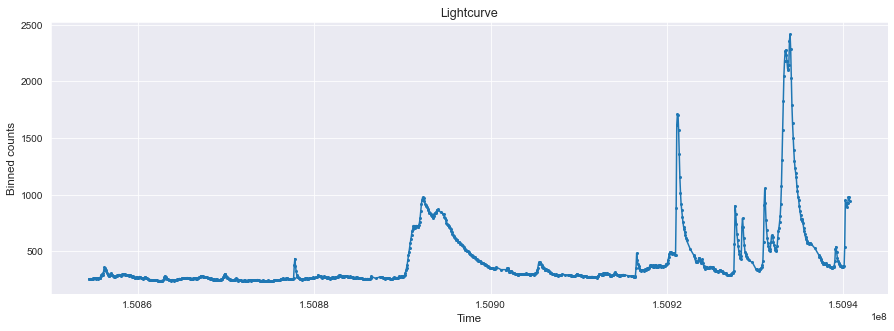

In [5]:
#Binning the lightcurve
binned_time, binned_count = np.array([]), np.array([])
bin = 70
for i in range(len(box_time)//bin):
    binned_time = np.concatenate((binned_time, [(box_time[bin*i]+box_time[bin*(i+1)])/2]))
    binned_count = np.concatenate((binned_count, [np.average(box_count[bin*i:bin*(i+1)])]))
plt.figure(0, figsize=(15,5))
plt.plot(binned_time, binned_count, marker = '.', markersize = 4)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Binned counts',fontsize = 11.5)

6.060085587616778
27
30


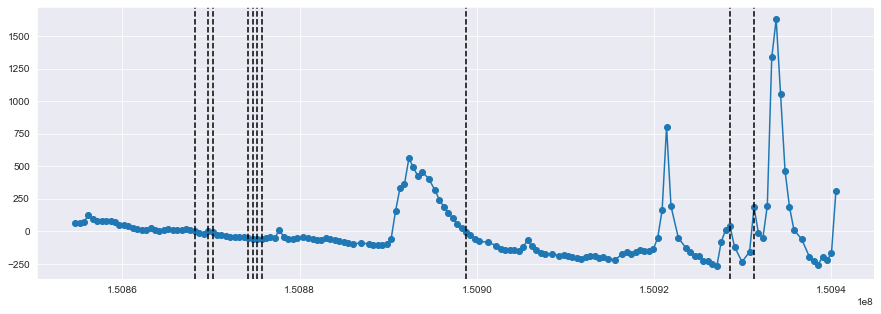

In [26]:
#Start of burst
st_nr = binned_count[4:]
st_dr = binned_count[:-4]
st_cutoff = np.average(np.sort(np.divide(st_nr, st_dr))[-20:])
st_flags = np.where(np.divide(st_nr, st_dr)>st_cutoff)
print(np.average(np.sort(np.divide(st_nr, st_dr))[-10:]))
print(st_flags[0][0])

#Peak of burst
peak = binned_count[st_flags[0][0]:]
pk_nr = peak[4:]
pk_dr = peak[:-4]
peak_flags = st_flags[0][0]+np.where(np.divide(pk_nr, pk_dr)<1)
print(peak_flags[0][0])

#End of burst
#zero_crossings = peak_flags[0][0]+np.where(np.where(np.diff(np.sign(np.divide(pk_nr, pk_dr)-1)))[0]>peak_flags[0][0])
#print(zero_crossings[0][0])

plt.figure(figsize = (15,5))
plt.plot(binned_time, binned_count,marker = 'o')

for i in range(min(len(st_flags[0]), len(peak_flags[0]))):  
    plt.axvline(binned_time[st_flags[0][i]], color = 'black', ls='--')
    plt.axvline(binned_time[peak_flags[0][i]], color = 'black', ls='--')
#plt.axvline(binned_time[zero_crossings[0][10]], color = 'red', ls='--')

In [27]:
print(np.ediff1d(st_flags[0]))

[ 4 54 54  4]


In [28]:
print(st_flags)

(array([ 27,  31,  85, 139, 143], dtype=int64),)


3.2857195879877836
894


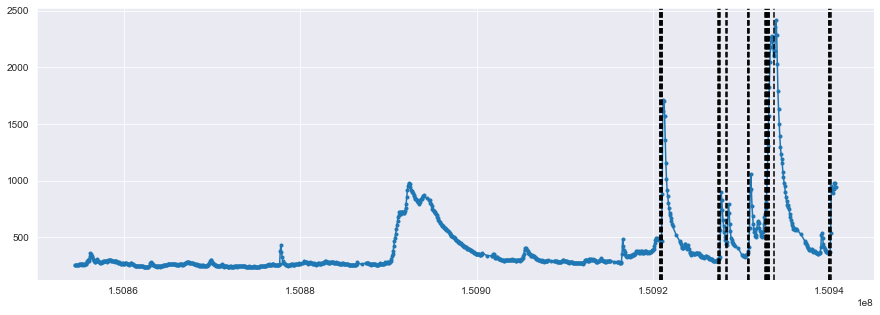

In [122]:
#Start of burst
st_nr = binned_count[4:]
st_dr = binned_count[:-4]
st_nr = st_nr - st_dr
st_dr = binned_time[4:] - binned_time[:-4]
st_cutoff = np.average(np.sort(np.divide(st_nr, st_dr))[-100:])
st_flags = np.array(np.where(np.divide(st_nr, st_dr)>st_cutoff))
print(np.average(np.sort(np.divide(st_nr, st_dr))[-10:]))
print(st_flags[0][0])

plt.figure(figsize = (15,5))
plt.plot(binned_time, binned_count,marker = '.')

for i in range(len(st_flags[0])):#, len(peak_flags[0]))):  
    plt.axvline(binned_time[st_flags[0][i]], color = 'black', ls='--')

307.0908078560106 62.7323474095074


Text(0, 0.5, 'Background subtracted counts')

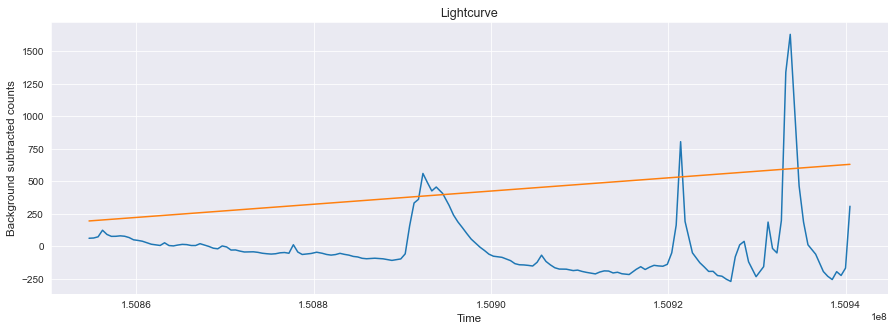

In [41]:
#Background subtraction
#Curvefit with a straight line
slope, intercept, r, p, se = linregress(binned_time, binned_count)
mean, med, sig = scs(binned_count)
print(mean, sig)
binned_counts_masked = binned_count[np.where(binned_count>mean+0.5*sig)]
bksub_counts = binned_count - np.array(slope*binned_time+intercept)
#count_rate = count_rate - np.array(slope*time+intercept)
plt.figure(0, figsize=(15,5))
plt.plot(binned_time, bksub_counts)
plt.plot(binned_time, slope*binned_time+intercept)
#plt.plot(time, count_rate)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Background subtracted counts',fontsize = 11.5)

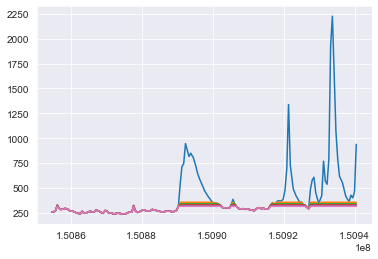

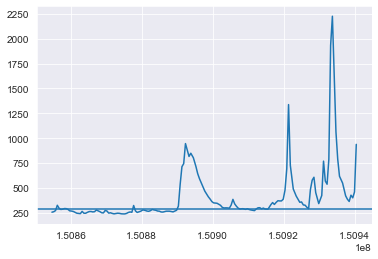

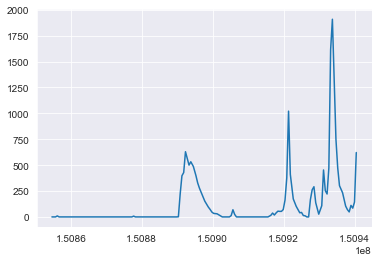

In [27]:
test_counts = np.copy(binned_count)
plt.plot(binned_time, test_counts)
iter = 5
n = 0.8
for i in range(iter):
    mean, med, sig = scs(test_counts)
    test_counts[test_counts>mean+n*sig]=mean+n*sig
    plt.plot(binned_time, test_counts)
mean, med, sig = scs(test_counts)
plt.plot(binned_time, test_counts)
plt.figure()
plt.plot(binned_time, binned_count)
plt.axhline(mean)
plt.figure()
plt.plot(binned_time, binned_count - test_counts)
print(np.where((binned_count - test_counts)>0))

cutoff :  0.4873619043795248


(array([1.50877530e+08, 1.50890476e+08, 1.50916284e+08, 1.50920764e+08,
        1.50927377e+08, 1.50930669e+08, 1.50938825e+08]),
 [150878089.926885,
  150899740.926885,
  150916913.926885,
  150924226.926885,
  150930108.926885,
  150938474.926885,
  150939804.926885])

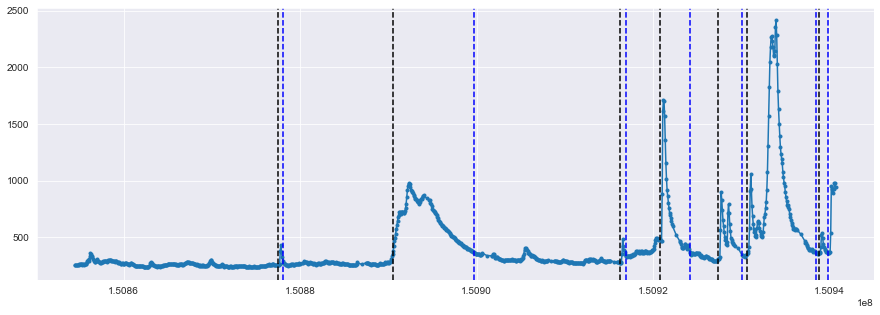

In [48]:
def local_maxima(binned_count, binned_time):
    length = 200
    st_nr = binned_count[4:]-binned_count[:-4]
    st_dr = binned_time[4:] - binned_time[:-4]
    st_cutoff = np.average(np.sort(np.divide(st_nr, st_dr))[-1*length:])
    st_flags = np.array(np.where(np.divide(st_nr, st_dr)>st_cutoff))
    print('cutoff : ', np.average(np.sort(np.divide(st_nr, st_dr))[-1*length:]))

    new_st_flags = [st_flags[0][0]]
    for i in range(len(st_flags[0])-1):
        if st_flags[0][i+1]-st_flags[0][i]>20:
            new_st_flags.append(st_flags[0][i+1])

    peak_flags = []

    for i in range(len(new_st_flags)):
        peak = binned_count[new_st_flags[i]:]
        #peak_flags.append(new_st_flags[i]+np.where(np.ediff1d(peak)<0)[0][0])
        pk_nr = peak[4:]
        pk_dr = peak[:-4]
        peak_flags.append(new_st_flags[i]+np.where(np.divide(pk_nr, pk_dr)<1)[0][5])

    def bk_avg():
        iter_counts = np.copy(binned_count)
        iter = 5
        n = 0.8
        for i in range(iter):
            mean, med, sig = scs(iter_counts)
            iter_counts[iter_counts>mean+n*sig]=mean+n*sig
        mean, med, sig = scs(iter_counts)
        return mean+3*sig

    cut = bk_avg()

    def find_end(time, counts, mean):
        if len(np.where(counts<mean)[0]) != 0:
            end_time = time[np.where(counts<mean)[0][0]]
        else:
            end_time = time[np.argmin(counts)]
        return end_time

    end_flags = []

    for i in range(len(peak_flags)):
        if i != len(peak_flags)-1:
            end_flags.append(find_end(binned_time[peak_flags[i]:new_st_flags[i+1]], binned_count[peak_flags[i]:new_st_flags[i+1]], cut))
        else:
            end_flags.append(find_end(binned_time[peak_flags[i]:], binned_count[peak_flags[i]:], cut))

    plt.figure(figsize = (15,5))
    plt.plot(binned_time, binned_count,marker = '.')

    for i in range(len(new_st_flags)):#, len(peak_flags[0]))):  
        plt.axvline(binned_time[new_st_flags[i]], color = 'black', ls='--')
        #plt.axvline(binned_time[peak_flags[i]], color = 'red', ls='--')
        plt.axvline(end_flags[i], color = 'blue', ls = '--')
        
    return binned_time[new_st_flags],end_flags

local_maxima(binned_count, binned_time)

[ 329  498  499  500  501  502  503  517  518  519  520  830  831  894
  895  896  897  898  979  980  981  982  991  992  993  994 1016 1017
 1018 1019 1020 1030 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049
 1050 1051 1052 1053 1058 1059 1060 1122 1123 1137 1138 1139 1140 1141] [169   1   1   1   1   1  14   1   1   1 310   1  63   1   1   1   1  81
   1   1   1   9   1   1   1  22   1   1   1   1  10  10   1   1   1   1
   1   1   1   1   1   1   1   1   1   5   1   1  62   1  14   1   1   1
   1]
[ 1  2  3  4  5  7  8  9 11 13 14 15 16 18 19 20 22 23 24 26 27 28 29 32
 33 34 35 36 37 38 39 40 41 42 43 44 46 47 49 51 52 53 54]


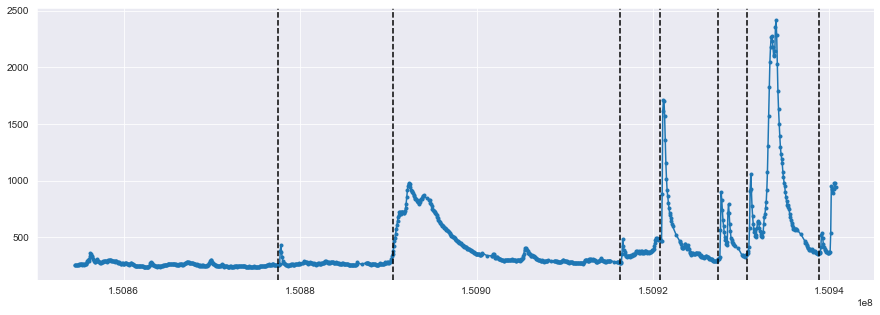

In [8]:
flag_diff = np.ediff1d(st_flags[0])
print(st_flags[0], flag_diff)
print(np.where(flag_diff==1)[0])
new_st_flags = st_flags[0][np.where(flag_diff>0)[0]]

try_flags = [st_flags[0][0]]
for i in range(len(st_flags[0])-1):
    if st_flags[0][i+1]-st_flags[0][i]>20:
        try_flags.append(st_flags[0][i+1])

new_st_flags = np.copy(try_flags)
plt.figure(figsize = (15,5))
plt.plot(binned_time, binned_count,marker = '.')

for i in range(len(new_st_flags)):#, len(peak_flags[0]))):  
    plt.axvline(binned_time[new_st_flags[i]], color = 'black', ls='--')
    
#print(np.ediff1d(st_flags[0]))
#print(np.where(np.ediff1d(st_flags[0])<50))

In [42]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


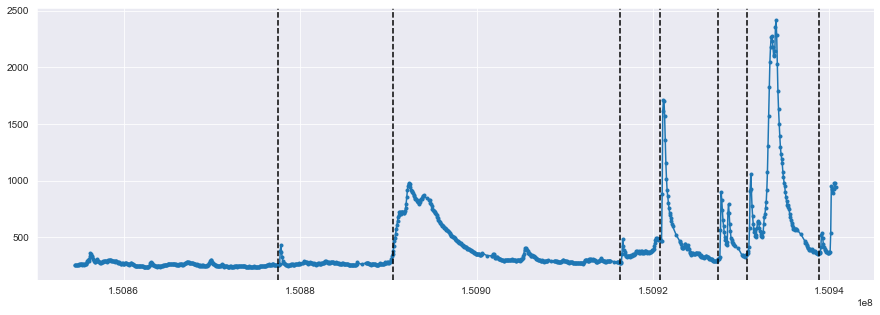

In [7]:
new_st_flags = [st_flags[0][0]]
for i in range(len(st_flags[0])-1):
    if st_flags[0][i+1]-st_flags[0][i]>20:
        new_st_flags.append(st_flags[0][i+1])

plt.figure(figsize = (15,5))
plt.plot(binned_time, binned_count,marker = '.')

for i in range(len(new_st_flags)):
    plt.axvline(binned_time[new_st_flags[i]], color = 'black', ls='--')

In [16]:
def bk_avg():
    test_counts = np.copy(binned_count)
    #plt.plot(binned_time, test_counts)
    iter = 5
    n = 0.8
    for i in range(iter):
        mean, med, sig = scs(test_counts)
        test_counts[test_counts>mean+n*sig]=mean+n*sig
        #plt.plot(binned_time, test_counts)
    mean, med, sig = scs(test_counts)
    #plt.plot(binned_time, test_counts)
    #plt.figure()
    #plt.plot(binned_time, binned_count)
    #plt.axhline(mean)
    #plt.figure()
    #plt.plot(binned_time, binned_count - test_counts)
    #print(np.where((binned_count - test_counts)>0))
    #print(mean)
    return mean+3*sig

bk_avg()

365.99743379192086

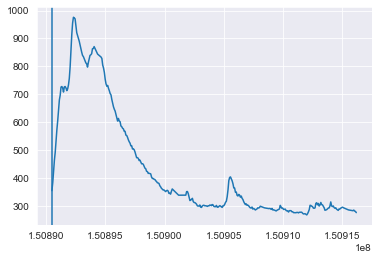

In [20]:
def find_end(time, counts, mean):
    if len(np.where(counts<mean)[0]) != 0:
        end_time = time[np.where(counts<mean)[0][0]]
    else:
        end_time = time[np.argmin(counts)]
    return end_time

fend_counts = binned_count[498:830]
fend_time = binned_time[498:830]
plt.plot(fend_time, fend_counts)
end_time = find_end(fend_time, fend_counts, bk_avg())
plt.axvline(end_time)
#i = 1 
#find_end(binned_time[new_st_flags[i]:new_st_flags[i+1]], binned_count[new_st_flags[i]:new_st_flags[i+1]], bk_avg())

In [ ]:
length = 200
st_nr = binned_count[4:] - binned_count[:-4]
st_dr = binned_time[4:] - binned_time[:-4]
st_cutoff = np.average(np.sort(np.divide(st_nr, st_dr))[-1*length:])
st_flags = np.array(np.where(np.divide(st_nr, st_dr)>st_cutoff))
print('cutoff : ', np.average(np.sort(np.divide(st_nr, st_dr))[-1*length:]))

plt.figure(figsize = (15,5))
plt.plot(binned_time, binned_count,marker = '.')

for i in range(len(st_flags[0])):#, len(peak_flags[0]))):  
    plt.axvline(binned_time[st_flags[0][i]], color = 'black', ls='--')

(array([], dtype=int64),) 0
280


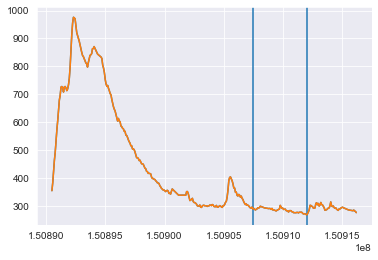

In [12]:
i = 1
fend_counts = binned_count[new_st_flags[i]:new_st_flags[i+1]]
fend_time = binned_time[new_st_flags[i]:new_st_flags[i+1]]
plt.plot(fend_time, fend_counts)
print(np.where(fend_counts<0), len(np.where(fend_counts<0)[0]))
print(np.argmin(fend_counts))
np.where(fend_counts<289)[0][0]
plt.axvline(fend_time[np.where(fend_counts<290)[0][0]])
plt.axvline(fend_time[np.argmin(fend_counts)])

def find_end(time, counts, mean):
    if len(np.where(counts<mean)[0]) != 0:
        end_time = np.where(counts<mean)[0][0]
    else:
        end_time = time[np.argmin(counts)]
    return end_time

#end_times = find_end(binned_time[new_st_flags[i]:new_st_flags[i+1]], binned_count[new_st_flags[i]:new_st_flags[i+1]], bk_avg())
#plt.plot(binned_time[new_st_flags[i]:new_st_flags[i+1]], binned_count[new_st_flags[i]:new_st_flags[i+1]])


[329, 498, 830, 894, 979, 1016, 1122] [150877529.926885, 150890739.926885]


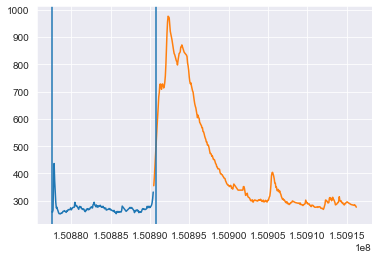

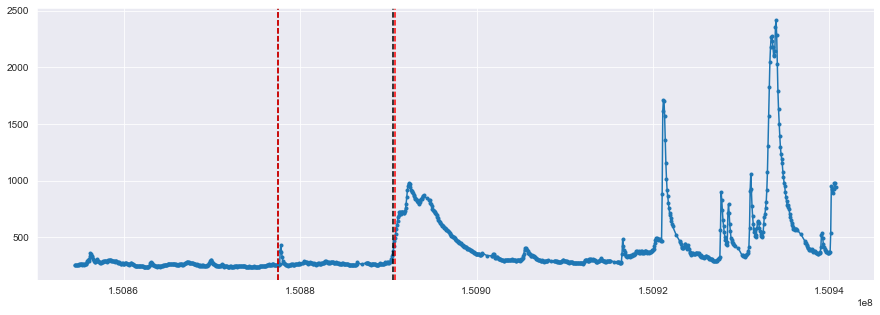

In [17]:
def find_end(time, counts, mean):
    if len(np.where(counts<mean)[0]) != 0:
        end_time = np.where(counts<mean)[0][0]
    else:
        end_time = time[np.argmin(counts)]
    return end_time

end_time = []
#for i in range(len(new_st_flags)-1):
for i in range(3-1):
    end_time.append(binned_time[new_st_flags[i]]+find_end(binned_time[new_st_flags[i]:new_st_flags[i+1]], binned_count[new_st_flags[i]:new_st_flags[i+1]], bk_avg()))
    plt.plot(binned_time[new_st_flags[i]:new_st_flags[i+1]], binned_count[new_st_flags[i]:new_st_flags[i+1]])
    plt.axvline(end_time[i])
    
print(new_st_flags, end_time)
plt.figure(figsize = (15,5))
plt.plot(binned_time, binned_count,marker = '.')

for i in range(2):
    plt.axvline(binned_time[new_st_flags[i]], color = 'black', ls='--')
    plt.axvline(end_time[i], color = 'red', ls = '--')

In [12]:
def smooth(binsize = 70, kernelsize = 8):
    box_bin = binsize
    kernel_size = kernelsize
    box_time, box_count = np.array([]), np.array([])
    for i in range(len(time[:])//box_bin):
        print(i)
        if(box_bin*i+i<=len(count_rate)):
            counts = count_rate[box_bin*i+i:box_bin*(i+1)+kernel_size+1+i]
            boxavg_counts = convolve(counts, Box1DKernel(kernel_size))[kernel_size//2:box_bin+kernel_size//2+1]
            box_count = np.concatenate((box_count, boxavg_counts))
            box_time = np.concatenate((box_time, time[box_bin*i+i+kernel_size//2:box_bin*(i+1)+kernel_size//2+1+i]))
            #plt.plot(time[box_bin*i:box_bin*(i+1)+kernel_size+1], counts, marker = '.', markersize = 3, alpha = 0.1)
        else:
            continue
    return box_time, box_count

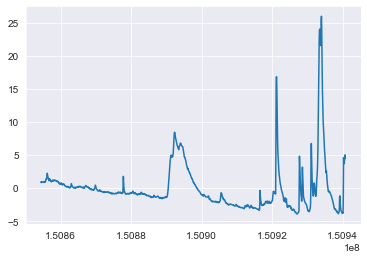

In [14]:
plt.plot(binned_time,binned_count/bin)
plt.show()

0.8446028746650845 157923910.23080263
1.1839883926472972
[1.42406387e-07 1.41999368e-07 1.41539062e-07 ... 4.71076735e-07
 3.88502035e-07 3.12108275e-07]


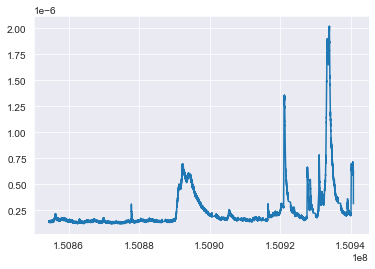

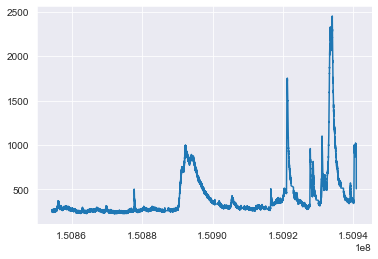

In [37]:
start_energy_flux=np.log10(3e-9)
start_count_rate=np.log10(1e1)
end_energy_flux=np.log10(7e-7)
end_count_rate=np.log10(1e3)
flux_slope=((end_count_rate-start_count_rate)/(end_energy_flux-start_energy_flux))
A = np.power(10, start_count_rate - flux_slope*start_energy_flux)
print(flux_slope, A)
print(1/flux_slope)
flux = np.power(np.array(box_count/A), 1/flux_slope)
print(flux)
plt.plot(box_time,flux)
plt.figure()
plt.plot(box_time,box_count)
class_A=1e-8
class_B=1e-7

In [22]:
def counts_to_flux(counts):
    start_energy_flux=np.log10(3e-9)
    start_count_rate=np.log10(1e1)
    end_energy_flux=np.log10(7e-7)
    end_count_rate=np.log10(1e3)
    flux_slope=((end_count_rate-start_count_rate)/(end_energy_flux-start_energy_flux))
    A = np.power(10, start_count_rate - flux_slope*start_energy_flux)
    print(flux_slope, A)
    print(1/flux_slope)
    flux = np.power(counts/A, 1/flux_slope)
    print(flux)

0.8446028746650845 157923910.23080263
1.1839883926472972
1.101608509941867e-08


In [ ]:
def n_sigma(time, counts, n):
    '''n-sigma : returns indices where counts>(mean+n*sigma)
    Returns flags, mean, sigma'''
    mean,_, sigma = scs(counts)
    #flags = np.where(counts>(mean+n*sigma)
    flags = np.where(counts>(mean+n*sigma))
    return flags, mean, sigma

def local_maxima(binned_count, binned_time):
    length = 200
    st_nr = binned_count[4:]-binned_count[:-4]
    st_dr = binned_time[4:] - binned_time[:-4]
    st_cutoff = np.average(np.sort(np.divide(st_nr, st_dr))[-1*length:])
    st_flags = np.array(np.where(np.divide(st_nr, st_dr)>st_cutoff))
    print('cutoff : ', np.average(np.sort(np.divide(st_nr, st_dr))[-1*length:]))

    new_st_flags = [st_flags[0][0]]
    for i in range(len(st_flags[0])-1):
        if st_flags[0][i+1]-st_flags[0][i]>20:
            new_st_flags.append(st_flags[0][i+1])

    peak_flags = []

    for i in range(len(new_st_flags)):
        peak = binned_count[new_st_flags[i]:]
        #peak_flags.append(new_st_flags[i]+np.where(np.ediff1d(peak)<0)[0][0])
        pk_nr = peak[4:]
        pk_dr = peak[:-4]
        peak_flags.append(new_st_flags[i]+np.where(np.divide(pk_nr, pk_dr)<1)[0][5])

    def bk_avg():
        iter_counts = np.copy(binned_count)
        iter = 5
        n = 0.8
        for i in range(iter):
            mean, med, sig = scs(iter_counts)
            iter_counts[iter_counts>mean+n*sig]=mean+n*sig
        mean, med, sig = scs(iter_counts)
        return mean+3*sig

    cut = bk_avg()

    def find_end(time, counts, mean):
        if len(np.where(counts<mean)[0]) != 0:
            end_time = time[np.where(counts<mean)[0][0]]
        else:
            end_time = time[np.argmin(counts)]
        return end_time

    end_flags = []

    for i in range(len(peak_flags)):
        if i != len(peak_flags)-1:
            end_flags.append(find_end(binned_time[peak_flags[i]:new_st_flags[i+1]], binned_count[peak_flags[i]:new_st_flags[i+1]], cut))
        else:
            end_flags.append(find_end(binned_time[peak_flags[i]:], binned_count[peak_flags[i]:], cut))

    plt.figure(figsize = (15,5))
    plt.plot(binned_time, binned_count,marker = '.')

    for i in range(len(new_st_flags)): 
        plt.axvline(binned_time[new_st_flags[i]], color = 'black', ls='--')
        #plt.axvline(binned_time[peak_flags[i]], color = 'red', ls='--')
        plt.axvline(end_flags[i], color = 'blue', ls = '--')
        
    return binned_time[new_st_flags],end_flags

def ns(self, time, rates):
    background_corrected_counts = self.bg_correction(time, rates)
    bin_time, bin_rates = self.rebin_lc(time, background_corrected_counts, 1.0, 25.0)
    flags, mean, sigma = n_sigma(time, rates, 3)
    return flags

def lm(self, time, rates):
    background_corrected_counts = self.bg_correction(time, rates)
    box_time, box_rates = self.smoothen(time, background_corrected_counts, 70, 8)
    bin_time, bin_rates = self.rebin_lc(box_time, box_rates, 1.0, 70.0)
    flags = local_maxima(bin_time, bin_rates)
    return flags

flags2 = np.arange(581, 628)

def EFP(x, A, B, C, D):
    Z = (2*B + C**2*D)/(2*C)
    return 1/2 * np.sqrt(np.pi) *  A * C * np.exp(D*(B-x) + C**2*D**2/4) * (erf(Z) - erf(Z - x/C))

def efp(self, time, rates):
    popt, pcov = curve_fit(EFP, np.float128(time[flags2]), np.float128(rates[flags2]), p0 =([25, 6000+1.5337e8, 17, 0.1]))
    #x2 = np.arange(1.533e8+75000, 1.533e8+77000)
    x2 = np.arange(1.533e8+74000, 1.533e8+78000)
    plt.scatter(time_new[flags2], counts_new[flags2])
    plt.plot(x2, EFP(x2, *popt))
    plt.savefig("efp_fit_1.png")
    chisq, p = chisquare(EFP(np.float128(time[flags2]), *popt), np.float128(rates[flags2]))
    return *popt, chisq